In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip drive/My\ Drive/cifar.zip

In [0]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-syeo5gqh
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-syeo5gqh
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.1.1-cp36-none-any.whl size=3641 sha256=f4e4b1923cd5756fdd4fd6af7b3ce6e4f7f1ee9a524e98290a4b07f48737b71e
  Stored in directory: /tmp/pip-ephem-wheel-cache-g710i_43/wheels/b7/24/83/d30234cc013cff538805b14df916e79091f7cf9ee2c5bf3a64
Successfully built warmup-scheduler


In [0]:
from warmup_scheduler import GradualWarmupScheduler

In [0]:
import torch
import torchvision
import glob
import os
import PIL
import time

In [0]:
train_imgs = glob.glob('./cifar/train/*.png')
test_imgs = glob.glob('./cifar/test/*.png')
labels = []
with open('./cifar/labels.txt','r') as f:
  labels = f.readlines()
num_classes = len(labels)
label_idx_dict = {label.replace('\n',''):idx for idx, label in enumerate(labels)}

In [0]:
transform_dict = {
    'train':torchvision.transforms.Compose([
                                            torchvision.transforms.RandomResizedCrop(32),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test':torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, imgs_path, label_idx_dict, transform=None):
    super(CIFAR10Dataset,self).__init__()
    self.imgs_path = imgs_path
    self.label_idx_dict = label_idx_dict
    self.num_imgs = len(imgs_path)
    self.transform = transform

  def __getitem__(self,idx):
    img_p = self.imgs_path[idx]
    img = PIL.Image.open(img_p)
    label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
    label_idx = self.label_idx_dict[label]

    if self.transform:
      img = self.transform(img)

    return img, label_idx

  def __len__(self):
    return self.num_imgs

In [0]:
batch_size = 128
num_epochs = 200
warmup_epochs=20

In [0]:
def main(warmup=False):
  lr=1e-4

  train_ds = CIFAR10Dataset(train_imgs, label_idx_dict, transform_dict['train'])
  test_ds = CIFAR10Dataset(test_imgs, label_idx_dict, transform=transform_dict['test'])

  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  net=torchvision.models.resnet18(pretrained=True)
  criterion=torch.nn.CrossEntropyLoss()
  if warmup:
    print('Warmup START!!')
    lr /= 10
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=60)
    scheduler=GradualWarmupScheduler(optimizer,multiplier=10,total_epoch=warmup_epochs,after_scheduler=scheduler)

  else:
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=70)
    print('No warmup START!!')




  device='cuda:0' if torch.cuda.is_available else 'cpu'
  torch.backends.cudnn.benchmark=True
  net.to(device)

  hist = {'loss':[],'acc':[],'val_loss':[],'val_acc':[],'lr':[]}

  for epoch in range(num_epochs):
    since = time.time()
    cur_lr = scheduler.get_lr()[0]
    hist['lr'].append(cur_lr)

    net.train()
    epoch_loss = 0.
    epoch_corrects = 0.
    epoch_imgs = 0.
    for batch in train_dl:
      imgs, labels = batch
      imgs, labels = imgs.to(device),labels.to(device)
      epoch_imgs += imgs.size(0)

      optimizer.zero_grad()
      outputs=net(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*imgs.size(0)
      epoch_corrects += sum(labels==outputs.argmax(1)).item()

    l = epoch_loss/epoch_imgs
    a = epoch_corrects/epoch_imgs

    hist['loss'].append(l)
    hist['acc'].append(a)

    print('Epoch {}: Loss {:.4f} Acc {:.4f} Time {:.2f} lr {}'.format(epoch+1,l,a,time.time()-since, cur_lr))

    val_loss = 0.
    val_corrects = 0.
    val_imgs = 0.
    for batch in test_dl:
      imgs, labels = batch
      imgs, labels = imgs.to(device), labels.to(device)
      val_imgs += imgs.size(0)

      with torch.no_grad():
        outputs=net(imgs)
        loss = criterion(outputs, labels)

      val_loss += loss.item()*imgs.size(0)
      val_corrects += sum(labels==outputs.argmax(1)).item()

    l = val_loss/val_imgs
    a = val_corrects/val_imgs

    hist['val_loss'].append(l)
    hist['val_acc'].append(a)

    print('Val: Loss {:.4f} Acc {:.4f}'.format(l, a))

    scheduler.step()

  return hist


## Warmup Epoch:100

In [0]:
hist = main(False)

No warmup START!!
Epoch 1: Loss 2.2485 Acc 0.4321 Time 27.67 lr 0.0001
Val: Loss 1.1508 Acc 0.6126
Epoch 2: Loss 1.1355 Acc 0.6112 Time 27.61 lr 0.0001
Val: Loss 0.9201 Acc 0.6856
Epoch 3: Loss 0.9997 Acc 0.6555 Time 27.47 lr 0.0001
Val: Loss 0.8290 Acc 0.7159
Epoch 4: Loss 0.9270 Acc 0.6818 Time 27.76 lr 0.0001
Val: Loss 0.7543 Acc 0.7428
Epoch 5: Loss 0.8803 Acc 0.6952 Time 27.54 lr 0.0001
Val: Loss 0.7099 Acc 0.7579
Epoch 6: Loss 0.8416 Acc 0.7080 Time 27.10 lr 0.0001
Val: Loss 0.6953 Acc 0.7634
Epoch 7: Loss 0.8049 Acc 0.7165 Time 27.02 lr 0.0001
Val: Loss 0.6674 Acc 0.7694
Epoch 8: Loss 0.7762 Acc 0.7290 Time 28.21 lr 0.0001
Val: Loss 0.6459 Acc 0.7781
Epoch 9: Loss 0.7619 Acc 0.7355 Time 29.25 lr 0.0001
Val: Loss 0.6334 Acc 0.7822
Epoch 10: Loss 0.7392 Acc 0.7432 Time 28.04 lr 0.0001
Val: Loss 0.6222 Acc 0.7846
Epoch 11: Loss 0.7203 Acc 0.7506 Time 27.97 lr 0.0001
Val: Loss 0.6120 Acc 0.7916
Epoch 12: Loss 0.7099 Acc 0.7539 Time 27.92 lr 0.0001
Val: Loss 0.5993 Acc 0.7924
Epoch 1

In [0]:
wu_hist = main(True)

Warmup START!!
Epoch 1: Loss 6.9385 Acc 0.0920 Time 28.31 lr 1e-05
Val: Loss 3.9714 Acc 0.2288
Epoch 2: Loss 2.6168 Acc 0.3619 Time 28.16 lr 1.45e-05
Val: Loss 1.8517 Acc 0.4487
Epoch 3: Loss 1.6913 Acc 0.4690 Time 28.56 lr 1.9e-05
Val: Loss 1.4284 Acc 0.5281
Epoch 4: Loss 1.4255 Acc 0.5267 Time 28.22 lr 2.3500000000000002e-05
Val: Loss 1.2331 Acc 0.5835
Epoch 5: Loss 1.2662 Acc 0.5686 Time 28.31 lr 2.8e-05
Val: Loss 1.1037 Acc 0.6222
Epoch 6: Loss 1.1636 Acc 0.6010 Time 28.10 lr 3.2500000000000004e-05
Val: Loss 1.0014 Acc 0.6581
Epoch 7: Loss 1.0824 Acc 0.6262 Time 28.02 lr 3.7000000000000005e-05
Val: Loss 0.9235 Acc 0.6809
Epoch 8: Loss 1.0283 Acc 0.6452 Time 28.20 lr 4.1500000000000006e-05
Val: Loss 0.8661 Acc 0.7041
Epoch 9: Loss 0.9683 Acc 0.6680 Time 28.01 lr 4.6e-05
Val: Loss 0.8331 Acc 0.7124
Epoch 10: Loss 0.9270 Acc 0.6777 Time 28.09 lr 5.05e-05
Val: Loss 0.7899 Acc 0.7308
Epoch 11: Loss 0.8929 Acc 0.6914 Time 28.03 lr 5.5e-05
Val: Loss 0.7619 Acc 0.7402
Epoch 12: Loss 0.8666

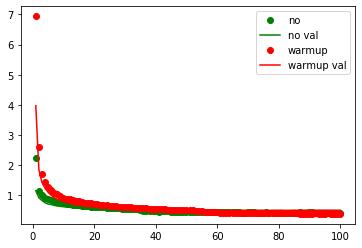

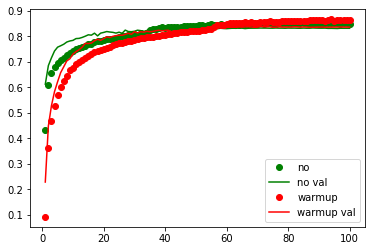

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1,num_epochs+1)
plt.plot(epochs, hist['loss'],'go',label='no')
plt.plot(epochs, hist['val_loss'],'g',label='no val')
plt.plot(epochs, wu_hist['loss'],'ro',label='warmup')
plt.plot(epochs, wu_hist['val_loss'],'r',label='warmup val')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, hist['acc'],'go',label='no')
plt.plot(epochs,hist['val_acc'],'g',label='no val')
plt.plot(epochs,wu_hist['acc'],'ro',label='warmup')
plt.plot(epochs,wu_hist['val_acc'],'r',label='warmup val')
plt.legend()
plt.show()

## Warmup Epoch:200

In [0]:
hist = main(False)

No warmup START!!
Epoch 1: Loss 2.2416 Acc 0.4359 Time 28.48 lr 0.0001
Val: Loss 1.1385 Acc 0.6130
Epoch 2: Loss 1.1387 Acc 0.6084 Time 28.67 lr 0.0001
Val: Loss 0.9021 Acc 0.6914
Epoch 3: Loss 0.9986 Acc 0.6544 Time 28.42 lr 0.0001
Val: Loss 0.8055 Acc 0.7228
Epoch 4: Loss 0.9351 Acc 0.6775 Time 28.22 lr 0.0001
Val: Loss 0.7642 Acc 0.7406
Epoch 5: Loss 0.8802 Acc 0.6959 Time 28.50 lr 0.0001
Val: Loss 0.7221 Acc 0.7565
Epoch 6: Loss 0.8384 Acc 0.7085 Time 28.27 lr 0.0001
Val: Loss 0.7014 Acc 0.7624
Epoch 7: Loss 0.8063 Acc 0.7213 Time 28.41 lr 0.0001
Val: Loss 0.6679 Acc 0.7743
Epoch 8: Loss 0.7765 Acc 0.7314 Time 28.34 lr 0.0001
Val: Loss 0.6465 Acc 0.7780
Epoch 9: Loss 0.7635 Acc 0.7371 Time 28.21 lr 0.0001
Val: Loss 0.6380 Acc 0.7799
Epoch 10: Loss 0.7403 Acc 0.7429 Time 28.44 lr 0.0001
Val: Loss 0.6324 Acc 0.7810
Epoch 11: Loss 0.7217 Acc 0.7494 Time 28.30 lr 0.0001
Val: Loss 0.6018 Acc 0.7919
Epoch 12: Loss 0.7060 Acc 0.7535 Time 28.61 lr 0.0001
Val: Loss 0.6045 Acc 0.7894
Epoch 1

In [0]:
wu_hist = main(True)

Warmup START!!
Epoch 1: Loss 6.9235 Acc 0.0917 Time 27.32 lr 1e-05
Val: Loss 3.9749 Acc 0.2290
Epoch 2: Loss 2.6312 Acc 0.3586 Time 27.40 lr 1.45e-05
Val: Loss 1.8664 Acc 0.4458
Epoch 3: Loss 1.6920 Acc 0.4741 Time 27.31 lr 1.9e-05
Val: Loss 1.4229 Acc 0.5309
Epoch 4: Loss 1.4160 Acc 0.5287 Time 27.54 lr 2.3500000000000002e-05
Val: Loss 1.2245 Acc 0.5845
Epoch 5: Loss 1.2689 Acc 0.5691 Time 27.33 lr 2.8e-05
Val: Loss 1.0897 Acc 0.6270
Epoch 6: Loss 1.1613 Acc 0.6017 Time 27.46 lr 3.2500000000000004e-05
Val: Loss 0.9862 Acc 0.6599
Epoch 7: Loss 1.0781 Acc 0.6302 Time 27.44 lr 3.7000000000000005e-05
Val: Loss 0.9266 Acc 0.6843
Epoch 8: Loss 1.0211 Acc 0.6484 Time 27.17 lr 4.1500000000000006e-05
Val: Loss 0.8657 Acc 0.7023
Epoch 9: Loss 0.9616 Acc 0.6652 Time 27.41 lr 4.6e-05
Val: Loss 0.8268 Acc 0.7158
Epoch 10: Loss 0.9288 Acc 0.6786 Time 27.30 lr 5.05e-05
Val: Loss 0.7875 Acc 0.7334
Epoch 11: Loss 0.8857 Acc 0.6926 Time 27.36 lr 5.5e-05
Val: Loss 0.7455 Acc 0.7414
Epoch 12: Loss 0.8602

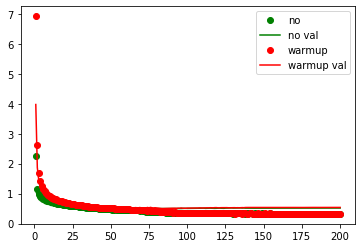

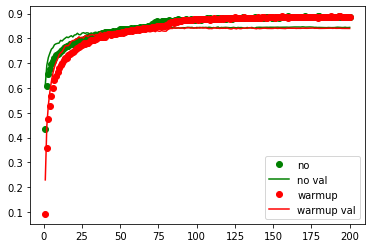

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1,num_epochs+1)
plt.plot(epochs, hist['loss'],'go',label='no')
plt.plot(epochs, hist['val_loss'],'g',label='no val')
plt.plot(epochs, wu_hist['loss'],'ro',label='warmup')
plt.plot(epochs, wu_hist['val_loss'],'r',label='warmup val')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, hist['acc'],'go',label='no')
plt.plot(epochs,hist['val_acc'],'g',label='no val')
plt.plot(epochs,wu_hist['acc'],'ro',label='warmup')
plt.plot(epochs,wu_hist['val_acc'],'r',label='warmup val')
plt.legend()
plt.show()

## Discussion
epoch:100
Warmup seems better than model without warmup.

## Experiments
1. Longer epochs(200)


## Results
1. Worse...